## A practical approach for the optimization of air monitoring networks using satellite data

In [1]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpAffineExpression
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

#### Processing the data

At this stage, the concentration data already obtained and grouped for each of the pollutants evaluated are ready and will be imported to carry out the optimization process.

Importing the average concentration, population density and water mask maps with the rasterio library:

In [2]:
dens_pop = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\dens_populacional.tif")
water = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\water.tif")
mCO = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\MEAN_CO.tif")
mNO = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\MEAN_NO2.tif")
mO = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\MEAN_O3.tif")
mSO = rio.open(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\MEAN_SO2.tif")

In [3]:
dens_arr = dens_pop.read()
water_arr = water.read()
mCO_arr = mCO.read()
mNO_arr = mNO.read()
mO_arr = mO.read()
mSO_arr = mSO.read()

In [4]:
# Matrices size (all must be the same)
print(dens_arr.shape,water_arr.shape,mCO_arr.shape,mNO_arr.shape,mO_arr.shape,mSO_arr.shape)

(1, 48, 63) (1, 48, 63) (1, 48, 63) (1, 48, 63) (1, 48, 63) (1, 48, 63)


Transforming matrices into 1D arrays:

In [5]:
dens_arr = dens_arr[0,:,:].flatten()
water_arr = water_arr[0,:,:].flatten()
mCO_arr = mCO_arr[0,:,:].flatten()
mNO_arr = mNO_arr[0,:,:].flatten()
mO_arr = mO_arr[0,:,:].flatten()
mSO_arr = mSO_arr[0,:,:].flatten()

print(dens_arr.shape,water_arr.shape,mCO_arr.shape,mNO_arr.shape,mO_arr.shape,mSO_arr.shape)

(3024,) (3024,) (3024,) (3024,) (3024,) (3024,)


Function for normalizing the data of each array to within the range [0,1]:

In [6]:
def normalize(array):
  normalized = np.zeros(len(array))
  min_arr = np.nanmin(array)
  max_arr = np.nanmax(array)
  for i in range(len(array)):
    normalized[i] = (array[i]-min_arr)/(max_arr-min_arr)

  return normalized

In [7]:
norm_dens = normalize(dens_arr)
norm_mCO = normalize(mCO_arr)
norm_mNO = normalize(mNO_arr)
norm_mO = normalize(mO_arr)
norm_mSO = normalize(mSO_arr)

Application of Jacob's Equation to group concentration data:

In [9]:
# Concentrations using Jordan Formula
concen = 1 - ((1-norm_mCO)*(1-norm_mNO)*(1-norm_mO)*(1-norm_mSO))

Visualizing the maps:

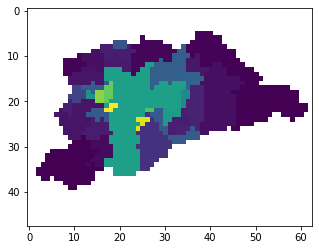

In [8]:
plt.imshow(norm_dens.reshape(48,63))

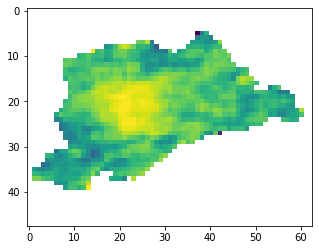

In [10]:
plt.imshow(concen.reshape(48,63))

In [11]:
concen = np.where(water_arr == 1,np.nan,concen)
concen = np.nan_to_num(concen)

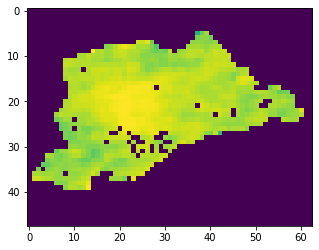

In [12]:
plt.imshow(concen.reshape(48,63))

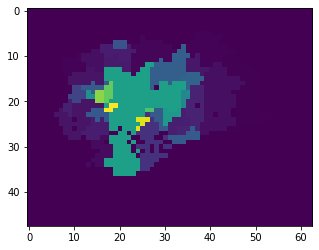

In [13]:
norm_dens = np.where(water_arr == 1,np.nan,norm_dens)
norm_dens = np.nan_to_num(norm_dens)
#norm_dens[norm_dens == np.nan] = 0
plt.imshow(norm_dens.reshape(48,63))

#### Building the optimization model using PulP lib

In [15]:
import copy

# Create the model
model = LpProblem(name="location-problem", sense=LpMaximize)

# Defining number of variables and creating faciliting locations
row = []
column = []

n = 48 # number of matrix rows
m = 63 # number of columns rows
variables = n*m

for i in range(0,n):
  for j in range(0,m):
    row.append(i)
    column.append(j)

facilities = list(zip(row,column))
print(variables)
print(facilities)

setup_cost = copy.copy(concen) 
population = copy.copy(norm_dens)

# Compute key parameters of MIP model formulation
num_population = len(population)

3024
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49

In [16]:
# Defining variables
x = [LpVariable("x{0}".format(i+1), cat="Binary") for i in range(variables)]

In [17]:
# Defining constraints
k = 0
model += (lpSum([x[(i)] for i in range(variables)]) <= 29) # limit stations, maximum of 29, in this example
model += (lpSum([x[i] for i in range(variables)]) >= 1) # at least 1 station 

# Distance constraints
for i in range(variables):
  for j in range(variables):
    if i != j:
      model += 3*(x[(i)] + x[(j)] - 1) <= int((np.sqrt((facilities[j][0]-facilities[i][0])**2+(facilities[j][1]-facilities[i][1])**2))) 

In [18]:
# Add the objective function to the model
mult = np.asarray(setup_cost)*np.asarray(population) 
oo = list(zip(x,mult))

opt = LpAffineExpression(oo)

model += opt 

In [19]:
import pulp

#pulp.pulpTestAll()

In [ ]:
#model.writeLP(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\file.lp")
#status = model.solve()

from pulp import GLPK_CMD
#status = model.solve(GLPK_CMD(timeLimit =800))
status = model.solve(GLPK_CMD())
#model.writeLP(r"D:\Usuarios\Xeon\Desktop\optimization_GIS\file_29stations_2d.lp")

In [ ]:
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

#for var in model.variables():
    #print(f"{var.name}: {var.value()}")

#for name, constraint in model.constraints.items():
 #   print(f"{name}: {constraint.value()}")

In [ ]:
# display optimal values of decision variables
loc = np.zeros(variables)
sum = 0
for i in range(len(model.variables())):
    sum = sum + x[i].value()
    #print(x[i],facilities[i])
    #print(var.value())
    if (abs(x[i].value()) == 1):
        print(x[i].value())
        print(x[i])
        print(facilities[i])
        loc[i] = 1


#print(loc)

setup_cost_array = np.asarray(setup_cost).reshape((n,m))
pop_array = np.asarray(population).reshape((n,m))
loc_array = np.asarray(loc).reshape((n,m))


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))


ax1.imshow(setup_cost_array, cmap = 'seismic')
ax2.imshow(pop_array, cmap = 'seismic')
im = ax3.imshow(loc_array, cmap = 'seismic')

#fig.colorbar(im)

#print(setup_cost_array)
#print(pop_array)

#### Saving location map as raster

It can be read in GIS.

In [ ]:
mCO_arr = mCO.read()
mCO_arr = np.asarray(mCO_arr[0,:,:])

In [ ]:
plt.imshow(mCO_arr)

In [ ]:
oi = np.isnan(mCO_arr)
print(oi)

In [ ]:
loc_float = loc_array.astype('float32')
loc_float[oi == True] = np.nan
plt.imshow(loc_float)

In [ ]:
type(mCO_arr)

In [ ]:
print(loc_float)

In [ ]:
stations_final = np.expand_dims(loc_float, axis=0)

In [ ]:
with rio.open(r'D:\Usuarios\Xeon\Desktop\optimization_GIS\x29stations_3d_2.tif', # Change save path
                   'w',driver='Gtiff', width=mCO.width, height=mCO.height,
                  count=1, crs=mCO.crs, transform=mCO.transform, dtype='float32') as stations:
    stations.write(stations_final)
    stations.close()